# InfoGAN Training Tutorials

Tutorial Goal: Learn how to train GAN and visualize the result.

## 1. Settings

### 1.1 Import required library

In [346]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils as vtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

## 2. Prepare Datasets

In [347]:
# Hyperparameters
image_size = 64
batch_size = 64

# Data preprocesssing
img_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loader
train_dataset = dset.MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = dset.MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 3. Define Models for Generator and Discriminator

### 3.1 Define Generator and Discriminator Class

In [348]:
class Generator(nn.Module):
    def __init__(self, latent_dim = 100, channel_dim=128, output_dim=1, categorical_dim = 1):
        super(Generator, self).__init__()
        # Q1
        # Hint: Use latent_dim and categorical_dim variables
        self.deconv1 = nn.ConvTranspose2d(latent_dim + categorical_dim, channel_dim*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(channel_dim*8)
        self.deconv2 = nn.ConvTranspose2d(channel_dim*8, channel_dim*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(channel_dim*4)
        self.deconv3 = nn.ConvTranspose2d(channel_dim*4, channel_dim*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(channel_dim*2)
        self.deconv4 = nn.ConvTranspose2d(channel_dim*2, channel_dim, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(channel_dim)
        self.deconv5 = nn.ConvTranspose2d(channel_dim, output_dim, 4, 2, 1)

    def forward(self, input):
        input = input.reshape(input.size(0), -1, 1, 1)
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, channel_dim=128, categorical_dim = 1):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, channel_dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(channel_dim, channel_dim*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(channel_dim*2)
        self.conv3 = nn.Conv2d(channel_dim*2, channel_dim*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(channel_dim*4)
        self.conv4 = nn.Conv2d(channel_dim*4, channel_dim*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(channel_dim*8)
        self.conv5 = nn.Conv2d(channel_dim*8, channel_dim, 4, 1, 0)             
        self.conv5_bn = nn.BatchNorm2d(channel_dim)
        self.real_ln = nn.Linear(channel_dim, 1)

        ## Q2
        self.classes_ln = nn.Linear(channel_dim, categorical_dim)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        x = x.view(input.shape[0], -1)

        ## Q3
        r = F.sigmoid(self.real_ln(x))                              
        classes = F.softmax(self.classes_ln(x))

        return r, classes


### 3.2 Build Generator and Discriminator model

In [349]:
# Generator and Discriminator
channel_dim = 128
latent_dim = 64
output_dim = 1 # Gray-scale image
num_category = 10 #For MNIST, 10 classes

generator = Generator(latent_dim = latent_dim, channel_dim = channel_dim, output_dim = output_dim, categorical_dim = num_category)
discriminator = Discriminator(channel_dim = channel_dim, categorical_dim=num_category)

# Use GPU or CPU
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

### 3.3 Check model parameters

In [350]:
num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12230273 and discriminator: 13116555


### 3.4 Weight initialization function

In [351]:
# custom weights initialization called on Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 3.5 Apply weight initialization on Generator and Discriminator

In [381]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (real_ln): Linear(in_features=128, out_features=1, bias=True)
  (classes_ln): Linear(in_features=128, out_features=10, bias=True)
)

### 3.6 Loss function and Optimizer

In [361]:
def hinge_d_loss(logits_real, logits_fake):
    loss_real = torch.mean(F.relu(1. - logits_real))
    loss_fake = torch.mean(F.relu(1. + logits_fake))
    d_loss = 0.5 * (loss_real + loss_fake)
    return d_loss

In [382]:
learning_rate = 1e-4
criterion = nn.BCELoss()
#criterion = hinge_d_loss
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
info_optimizer = torch.optim.Adam(params=list(generator.parameters()) + list(discriminator.parameters()), lr = learning_rate, betas=(0.5, 0.9))

## 4. Train DCGAN

### 4.1 Fix latent noise for visualization

In [372]:
test_batch_size=100

# discrete latent code  
labels = torch.randint(0, 10, (test_batch_size,)).to(device)
labels_class = F.one_hot(labels, num_classes=num_category)

# random gaussian noise
fixed_latent = torch.randn(test_batch_size, latent_dim, device=device)

# Concat channelwise
fixed_latent = torch.cat((fixed_latent, labels_class), dim=1)

### 4.2 Train Generator and Discriminator over training dataset

Training ...


/tmp/ipykernel_2980626/3847425162.py:63: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  classes = F.softmax(self.classes_ln(x))


Epoch [1 / 7] average loss generator vs. discrim. vs. info: 43.897266 vs. 0.930277 vs. 1.549334


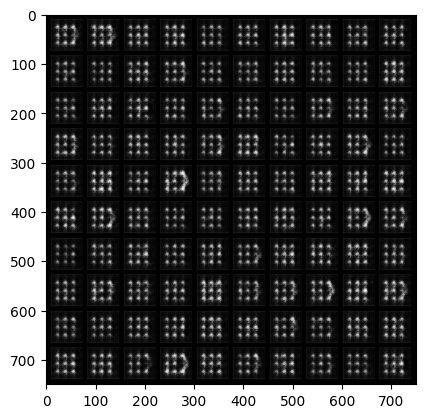

Epoch [2 / 7] average loss generator vs. discrim. vs. info: 26.875789 vs. 0.359299 vs. 1.487752


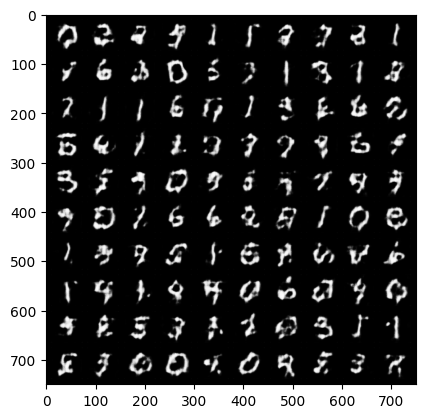

Epoch [3 / 7] average loss generator vs. discrim. vs. info: 24.168794 vs. 0.366214 vs. 1.485111


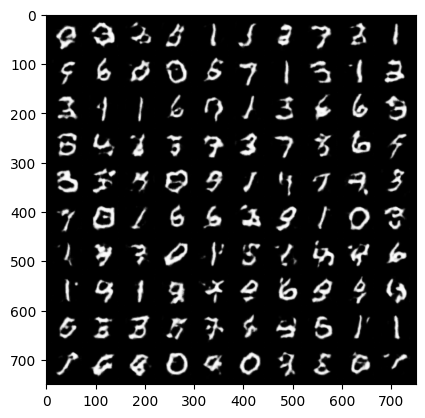

Epoch [4 / 7] average loss generator vs. discrim. vs. info: 24.307854 vs. 0.358247 vs. 1.478099


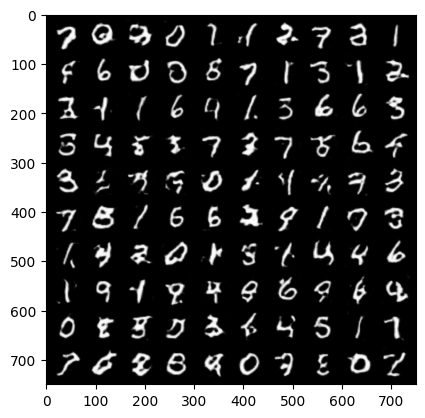

Epoch [5 / 7] average loss generator vs. discrim. vs. info: 26.393529 vs. 0.335792 vs. 1.473056


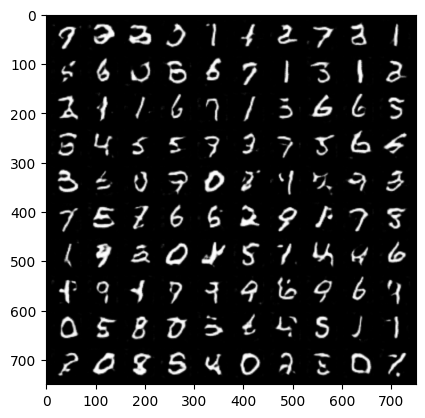

Epoch [6 / 7] average loss generator vs. discrim. vs. info: 28.378362 vs. 0.312723 vs. 1.469740


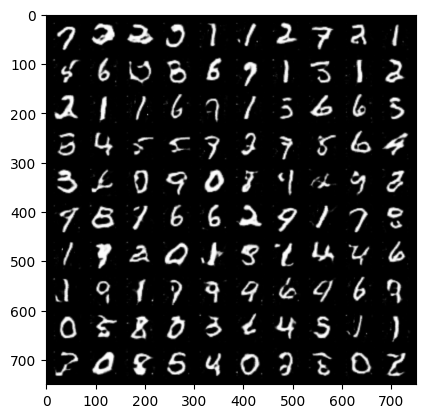

Epoch [7 / 7] average loss generator vs. discrim. vs. info: 30.790428 vs. 0.292725 vs. 1.468966


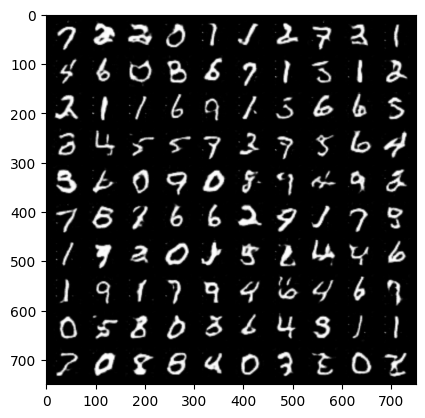

In [383]:
# set training epochs
torch.use_deterministic_algorithms(False)
num_epochs = 7

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []
info_loss_avg = []
img_list = []
iters = 0

print('Training ...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    info_loss_avg.append(0)
    num_batches = 0
    
    for i, (image_batch, _) in enumerate(train_dataloader):

        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        labels = torch.randint(0, 10, (image_batch.size(0),)).to(device)
        labels_class = F.one_hot(labels, num_classes=num_category)
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        latent = torch.cat([latent, labels_class], dim = 1)
        fake_image_batch = generator(latent)

        # Update discriminator
        real_pred, _ = discriminator(image_batch)
        real_pred = real_pred.squeeze()
        fake_pred, _ = discriminator(fake_image_batch.detach())
        fake_pred = fake_pred.squeeze()
        disc_loss = 0.5 * (
           criterion(real_pred, label_real*0.9) +
           criterion(fake_pred, label_fake))
        #disc_loss = criterion(real_pred, fake_pred)

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        
        # Update generator
        fake_pred, _ = discriminator(fake_image_batch)
        fake_pred = fake_pred.squeeze()

        gen_loss = 10 * criterion(fake_pred, label_real)
        #gen_loss = -10*(torch.mean(fake_pred))
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # generate a batch of images from latent prior
        labels = torch.randint(0, 10, (image_batch.size(0),)).to(device)
        labels_class = F.one_hot(labels, num_classes=num_category).float()
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        latent = torch.cat((latent, labels_class), dim=1)        
        fake_image_batch = generator(latent)

        # Measure mutual information between classifier Q and latent code c
        # Update discriminator and generator
        _, labels_pred = discriminator(fake_image_batch)
        
        # Q4
        info_loss = F.cross_entropy(labels_pred, labels_class)
        

        info_optimizer.zero_grad()
        info_loss.backward()
        info_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        info_loss_avg[-1] += info_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    info_loss_avg[-1] /= num_batches
    print(f'Epoch [{epoch + 1} / {num_epochs}] average loss generator vs. discrim. vs. info: {gen_loss_avg[-1]} vs. {disc_loss} vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1], info_loss_avg[-1]))

    # Visualization during training
    generator.eval()
    with torch.no_grad():
        fake = generator(fixed_latent).detach().cpu()
        #fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(np.transpose(vtils.make_grid(fake, 10, padding=10, normalize=True).cpu(),(1,2,0)))
    plt.show()
    generator.train()

## 5. Visualizing Training Results

### 5.1 Loss vs. training iteration

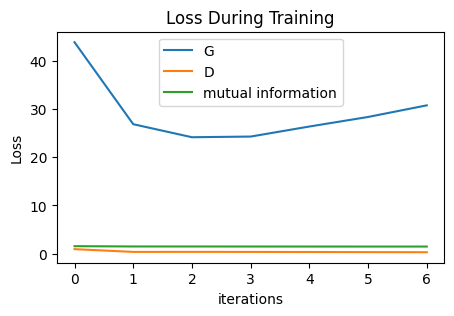

In [384]:
plt.figure(figsize=(5,3))
plt.title("Loss During Training")
plt.plot(gen_loss_avg, label="G")
plt.plot(disc_loss_avg, label="D")
plt.plot(info_loss_avg, label="mutual information")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 5.2 Visualization of Generator output

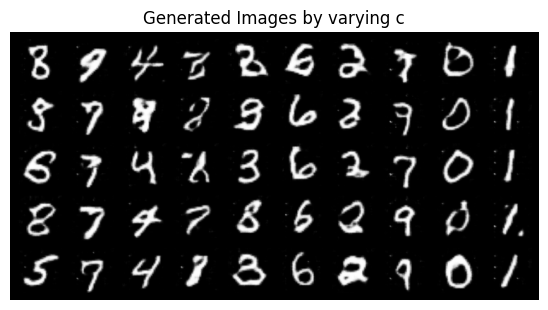

In [385]:
with torch.no_grad():

    latent = torch.randn(50, latent_dim, device=device)
    latents = torch.Tensor([torch.randn(latent_dim).repeat(10, 1).tolist() for i in range(5)]).reshape(50, -1).to(device)
    codes = F.one_hot(torch.arange(num_category).repeat(5).to(device), num_classes=10)
    #cont = torch.Tensor([torch.randn(num_continuous).repeat(10, 1).tolist() for i in range(5)]).reshape(50, -1).to(device)
    
    latent = torch.cat((latent, codes), dim=1)

    fake_image_batch = generator(latent).cpu()
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Generated Images by varying c")
    plt.imshow(np.transpose(vtils.make_grid(fake_image_batch, 10, padding=10, normalize=True).cpu(),(1,2,0)))